In [1]:
from datetime import datetime, timedelta
from netrc import netrc
import numpy as np
import os
from onc import ONC
import pandas as pd
import xarray as xr
from xarray.groupers import BinGrouper

import matplotlib.pyplot as plt

## Util/Xarray Funcs

In [2]:
FlagTerm = 'flag'

def dt2str(dt: datetime) -> str:
    dtstr = dt.strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3] + 'Z'
    return dtstr


def get_onc_token_from_netrc(netrc_path: os.PathLike | None = None, machine: str = 'data.oceannetworks.ca') -> str:
    if netrc_path is None:
        _, __, onc_token = netrc().authenticators(machine)
    else:
        _, __, onc_token = netrc(netrc_path).authenticators(machine)
    return onc_token


def nan_onc_flags(ds: xr.Dataset, flags_to_nan: list[int] = [4]) -> xr.Dataset:
    flag_vars = [v for v in ds.data_vars if v.startswith(FlagTerm)]
    if len(flag_vars) != 0:
        for fv in flag_vars:
            dv = fv.replace(FlagTerm + '_', '')
            if dv in ds.data_vars:
                ds[dv] = ds[dv].where(~ds[fv].isin([flags_to_nan]), np.nan)
    return ds


def remove_onc_flag_vars(ds: xr.Dataset) -> xr.Dataset:
    flag_vars = [v for v in ds.data_vars if v.startswith(FlagTerm)]
    if len(flag_vars) != 0:
        ds = ds.drop_vars(flag_vars, errors='ignore')
    return ds


def json2xarray(json_response_data: dict, join_method: str = 'outer') -> xr.Dataset:

    # Light checks because this function only handles certain conditions.
    if json_response_data['parameters']['outputFormat'].lower() != 'array':
        raise NotImplementedError("Only 'array' outputFormat is currently supported.")
    elif json_response_data['parameters']['metaData'].lower() != 'full':
        raise NotImplementedError("Only 'full' metadata is currently supported.")

    loc_code = json_response_data['parameters']['locationCode'].upper()

    cit = json_response_data['citations']
    doi_info = [c['citations'] for c in cit] if len(cit) > 1 else cit[0]['citation']

    metadata = json_response_data['metadata']
    depth = metadata['depth']
    dev_cat_code = metadata['deviceCategoryCode']
    loc_name = metadata['locationName']

    qaqc_flag_info = '\n'.join([f"{k}:{v}" for k, v in
                                json_response_data['qaqcFlagInfo'].items()])

    device_data = json_response_data['sensorData']

    vds_list = []
    for var_data in device_data:  # This could probably be parallelized in the future.

        # The sensorName is more descriptive than the propertyCode.
        var_name = var_data['sensorName'].replace(' ', '_')
        var_name = var_name.replace('-', '_')
        var_name = var_name.replace('(', '')
        var_name = var_name.replace(')', '')
        var_name = var_name.lower()

        flag_var_name = f"{FlagTerm}_{var_name}"

        var_times = var_data['data']['sampleTimes']
        var_values = var_data['data']['values']
        var_flags = var_data['data']['qaqcFlags']

        vds = xr.Dataset()
        vds = vds.assign_coords({'time': pd.to_datetime(var_times).tz_localize(None)})
        vds[var_name] = (('time'), var_values)
        vds[flag_var_name] = (('time'), var_flags)

        # Fill any potential NaNs with a flag indicating no QAQC performed (0).
        vds[flag_var_name] = vds[flag_var_name].fillna(0)

        # Convert time dtypes to reduce object size.
        vds['time'] = vds['time'].astype('datetime64[ms]')
        vds[flag_var_name] = vds[flag_var_name].astype('int8')

        # Assign variable level attributes.
        vds[var_name].attrs['units'] = var_data['unitOfMeasure']
        vds[var_name].attrs['long_name'] = var_data['sensorName']
        vds[var_name].attrs['propertyCode'] = var_data['propertyCode']
        vds[var_name].attrs['sensorCategoryCode'] = var_data['sensorCategoryCode']
        vds[var_name].attrs['sensorName'] = var_data['sensorName']
        vds[var_name].attrs['sensorCode'] = var_data['sensorCode']
        vds[var_name].attrs['deviceCategoryCode'] = dev_cat_code

        vds[flag_var_name].attrs['variable'] = var_name
        vds[flag_var_name].attrs['qaqcFlagInfo'] = qaqc_flag_info

        vds['time'].attrs['timezone'] = 'UTC'

        vds_list.append(vds)

    ds = xr.combine_by_coords(vds_list, join=join_method)
    ds = ds[sorted(ds.data_vars)]

    # Assign root level attributes.
    ds.attrs['locationCode'] = loc_code
    ds.attrs['locationName'] = loc_name
    ds.attrs['deviceCategoryCode'] = dev_cat_code
    ds.attrs['citations'] = doi_info
    ds.attrs['qaqcFlagInfo'] = qaqc_flag_info
    if 'depth' not in ds.data_vars:
        ds.attrs['depth'] = depth
    return ds

## QAQC Funcs

In [3]:
class FLAG:
    NOT_EVALUATED: int = 0
    PASS: int = 1
    HIGH_INTEREST: int = 2
    SUSPECT: int = 3
    FAIL: int = 4
    MISSING_DATA: int = 9


def location_test(latitude: xr.DataArray, longitude: xr.DataArray) -> xr.DataArray:
    """
    Determine if a given latitude and longitude are valid.
    This is a modified version of the QARTOD location test.

    :param latitude: xr.DataArray of lat values with a 'time' coordinate.
    :param longitude: xr.DataArray of lon values with a 'time' coordinate that has the same timestamps as the lat.
    :return: xr.DataArray of test flag.
    """

    # Assign NOT_EVALUATED by default.
    flag = xr.full_like(latitude, fill_value=FLAG.NOT_EVALUATED).astype('int8')

    # Assign PASS/FAIL flags.
    flag = flag.where((np.abs(latitude) < 90) | (np.abs(longitude) < 180), FLAG.FAIL)
    flag = flag.where((np.abs(latitude) > 90) & (np.abs(longitude) > 180), FLAG.PASS)

    # Set to missing if nan.
    flag = flag.where(~np.isnan(latitude) | ~np.isnan(longitude), FLAG.MISSING_DATA)
    return flag


def gross_range_test(data: xr.DataArray,
                     sensor_min: float, sensor_max: float,
                     operator_min: float or None = None,
                     operator_max: float or None = None) -> xr.DataArray:
    """
    Determine if data are within appropriate sensor or operator defined ranges.

    :param data: The input data.
    :param sensor_min: The minimum value the sensor can observe.
    :param sensor_max: The maximum value the sensor can observe.
    :param operator_min: An operator/user defined minimum value.
        Example: Minimum factory calibrated value.
    :param operator_max: An operator/user defined maximum value.
        Example: Maximum factory calibrated value.
    :return: An xr.DataArray of flag.
    """

    flag = xr.full_like(data, fill_value=FLAG.NOT_EVALUATED).astype('int8')

    flag = flag.where((data < sensor_min) & (data > sensor_max), FLAG.PASS)
    flag = flag.where((data > sensor_min) | (data < sensor_max), FLAG.FAIL)

    if operator_min is not None:
        if sensor_min != operator_min:
             flag = flag.where((data > operator_min) | (data < sensor_min), FLAG.SUSPECT)
    if operator_max is not None:
        if sensor_max != operator_max:
            flag = flag.where((data < operator_max) | (data > sensor_max), FLAG.SUSPECT)

    flag = flag.where(~np.isnan(data), FLAG.MISSING_DATA)


    return flag


def spike_test(data: xr.DataArray, spike_half_window: int = 1, std_half_window: int = 15,
               low_multiplier: float = 3, high_multiplier: float = 5):
    """
    Run a dynamic spike test on a given DataArray. 

    :param data: The input xr.DataArray.
    :param spike_window: The window size to use for identifying spikes.
        Default is 3 (n-1, n, n+1).
    :param std_window: The window size to use for identifying a rolling
        standard deviation.
    :param low_multiplier: The multiplier to use for flagging data as SUSPECT.
    :param high_multiplier: The multiplier to use for flagging data as FAIL.
    :return: An xr.DataArray of flags with the same dimensions as the input DataArray.
    """

    data = data.sortby('time') # Sort input by time.

    spkref_windows = data.rolling({'time': spike_half_window * 2 + 1}, min_periods=1).construct('window')
    spkref_left = spkref_windows[:, 0]
    spkref_right = spkref_windows[:, -1]
    spkref = (spkref_left + spkref_right) / 2

    sd = data.rolling({'time': std_half_window * 2 + 1}, center=True, min_periods=1).std()
    threshold_low = low_multiplier * sd
    threshold_high = high_multiplier * sd

    flag = xr.full_like(data, FLAG.NOT_EVALUATED).astype('int8')
    flag = flag.where(~(np.abs(data - spkref) < threshold_low) & ~(np.abs(data - spkref) > threshold_high),
                            FLAG.PASS)
    flag = flag.where((np.abs(data - spkref) < threshold_low) | (np.abs(data - spkref) > threshold_high),
                            FLAG.HIGH_INTEREST)
    flag = flag.where(~(np.abs(data - spkref) > threshold_high), FLAG.FAIL)
    flag = flag.where((~np.isnan(data)), FLAG.MISSING_DATA)
    flag = flag.where((~np.isnan(spkref)), FLAG.MISSING_DATA)
    flag = flag.where((~np.isnan(threshold_low)) | (~np.isnan(threshold_high)), FLAG.NOT_EVALUATED)

    return flag


def flat_line_test(data: xr.DataArray,
                   max_allowed_std: float = 0,
                   fail_half_window_size: int = 5,
                   suspect_half_window_size: int = 3) -> xr.DataArray:
    """
    Run a modified flat line test on a DataArray. This test is a modified version of the QARTOD flat line test.

    :param data: An xr.DataArray of data.
    :param fail_half_window_size: The half window size (in number of time steps) to use for the fail test.
    :param suspect_half_window_size: The half window size (in number of time steps) to use for the suspect test.
    :param max_allowed_std: The maximum standard deviation allowed to be considered a flat line.
    :return: An xr.DataArray of flags with the same dimensions as the input DataArray.
    """

    # Fail Window Construction
    wf = data.rolling({'time': fail_half_window_size * 2 + 1}).construct('window')
    wfstd = wf.std(dim='window')

    # Suspect Window Construction
    ws = data.rolling({'time': suspect_half_window_size * 2 + 1}).construct('window')
    wsstd = ws.std(dim='window')

    flag = xr.full_like(data, FLAG.NOT_EVALUATED, dtype='int8')
    flag = xr.where(wsstd <= max_allowed_std, FLAG.SUSPECT, flag) # Flag suspect values.
    flag = xr.where(wfstd <= max_allowed_std, FLAG.FAIL, flag) # Flag bad values.
    flag = xr.where(flag == FLAG.NOT_EVALUATED, FLAG.PASS, flag)

    return flag

## Processing Funcs

In [4]:
def split_periods(da_time: xr.DataArray, min_gap: int = 60 * 5) -> list[dict]:
    """
    Split a time series into periods of time containing data with a specified minimum gap in between each period.

    :param da_time: A time-indexed xarray DataArray.
    :param min_gap: The minimum number of seconds between data points that constitutes a break in the time series.
    :return: A list of dictionaries with 'begin_datetime' and 'end_datetime' keys for each period.
    """

    # First sort the data by time if it isn't already sorted.
    da_time = da_time.sortby('time')

    # Identify periods of time where data are separated by more than the # of seconds specified by `separation_time`.
    dts = list(da_time.where(da_time['time'].diff('time') > np.timedelta64(min_gap, 's'), drop=True).get_index('time'))

    if da_time.time.min() != dts[0]:
        dts = [pd.to_datetime(da_time.time.min().values)] + dts

    periods = []
    for dt in dts:
        if dt == dts[-1]:
            start = dt
            stop = None
        else:
            dtidx = dts.index(dt)
            start = dt
            stop = dts[dtidx + 1] - timedelta(seconds=30)  # Look back by 30 seconds to ensure we do not capture next.
        period = da_time.sel(time=slice(start, stop))
        if len(period.time.values) == 0:
            continue
        else:
            _p = {'begin_datetime': pd.to_datetime(period.time.min().values),
                  'end_datetime': pd.to_datetime(period.time.max().values)}
            periods.append(_p)
    if len(periods) == 0:
        _p = {'begin_datetime': pd.to_datetime(da_time.time.min().values),
              'end_datetime': pd.to_datetime(da_time.time.max().values)}
        periods = [_p]
    return periods



def identify_profiles(cable_length, profile_direction: str = 'all',
                      buffer: int = 10,
                      max_allowed_std: float = 0.02, min_gap: int = 180):
    flag_cl = flat_line_test(cable_length, max_allowed_std=max_allowed_std)
    profiling_state = flag_cl.where(flag_cl == 1, drop=True)
    profiles = split_periods(profiling_state, min_gap = min_gap)

    assigned_profiles = []
    for profile in profiles:
        _cl = cable_length.sel(time=slice(profile['begin_datetime'], profile['end_datetime']))
        _start = _cl.sel(time=_cl.time.min())
        _stop = _cl.sel(time=_cl.time.max())
        if _start - _stop > 0:
            profile_dir = 'down'
        else:
            profile_dir = 'up'

        profile['direction'] = profile_dir
        profile['begin_datetime'] = pd.to_datetime(profile['begin_datetime'] - np.timedelta64(buffer, 's'))
        profile['end_datetime'] = pd.to_datetime(profile['end_datetime'] + np.timedelta64(buffer, 's'))

        assigned_profiles.append(profile)

    if profile_direction == 'all':
        return assigned_profiles
    elif profile_direction == 'up':
        up_pros = [p for p in assigned_profiles if p['direction'] == 'up']
        return up_pros
    elif profile_direction == 'down':
        down_pros = [p for p in assigned_profiles if p['direction'] == 'down']
        return down_pros

def identify_stops(cable_length, buffer: int = 10, max_allowed_std: float = 0.01):
    flag_cl = flat_line_test(cable_length, max_allowed_std=max_allowed_std)
    stop_state = flag_cl.where(flag_cl != 1, drop = True)
    stops = split_periods(stop_state, min_gap = 60)

    assigned_stops = []
    for stop in stops:
        _cl = cable_length.sel(time = slice(stop['begin_datetime'], stop['end_datetime']))
        stop_cl_out = int(np.ceil(_cl.median()))
        stop['begin_datetime'] = pd.to_datetime(stop['begin_datetime']) - np.timedelta64(buffer,'s')
        stop['end_datetime'] = pd.to_datetime(stop['end_datetime']) + np.timedelta64(buffer,'s')
        stop['cable_length_out'] = stop_cl_out
        assigned_stops.append(stop)
    return stops



## Example Usage BACVP CTD Profiles

In [5]:
onc = ONC(token = get_onc_token_from_netrc())

In [6]:
loc_code = 'BACVP'
date_from = dt2str(datetime(2025,7,1,0,0,0,0)) # Start of the data request.
date_to = dt2str(datetime(2025,7,1,23,59,59,999999)) # End of the data request.

In [7]:
dev_cat_code = 'DC90'
params = {'locationCode': loc_code,
          'deviceCategoryCode': dev_cat_code,
          'dateFrom': date_from,
          'dateTo': date_to,
          'metadata': 'full',
          'qualityControl': 'raw',
          'rowLimit': 100000,
          'outputFormat': 'array',
          'propertyCode': 'length'}
json_response_data = onc.getScalardata(filters=params, allPages=True)
cable_length = json2xarray(json_response_data)
cable_length = nan_onc_flags(cable_length, flags_to_nan=[4])
cable_length = cable_length.cable_length
up_profiles = identify_profiles(cable_length, profile_direction = 'up')

Data quantity is greater than the row limit and will be downloaded in multiple pages.
Estimated approx. 5 pages in total.
Estimated approx. 5 seconds to complete for the rest of the pages.

   (100000 samples) Downloading page 2...
   (200000 samples) Downloading page 3...
   (300000 samples) Downloading page 4...
   (342137 samples) Completed in 4 seconds.


In [8]:
ctd_profiles = []
for up_profile in up_profiles:
    dev_cat_code = 'CTD'
    params = {'locationCode': loc_code,
              'deviceCategoryCode': dev_cat_code,
              'dateFrom': dt2str(up_profile['begin_datetime']),
              'dateTo': dt2str(up_profile['end_datetime']),
              'metadata': 'full',
              'qualityControl': 'raw',
              'rowLimit': 100000,
              'outputFormat': 'array'}
    json_response_data = onc.getScalardata(filters = params, allPages=True)
    ctd = json2xarray(json_response_data)
    ctd = nan_onc_flags(ctd, flags_to_nan=[4])
    ctd_profiles.append(ctd)

Text(0.5, 1.0, 'BACVP Temperature Profiles')

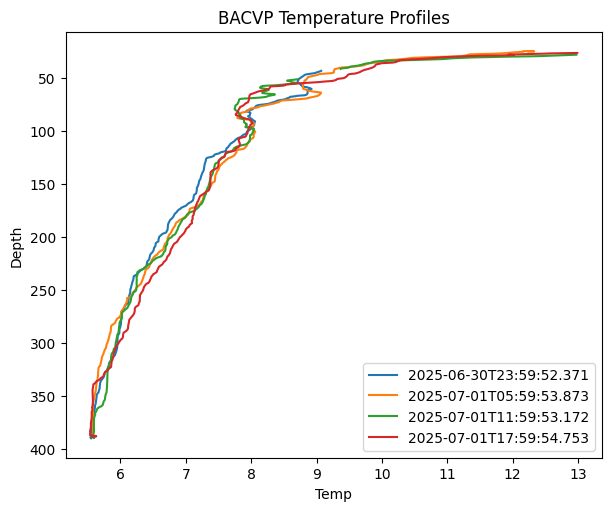

In [9]:
fig, ax = plt.subplots(1,1,figsize = (6,5), constrained_layout = True)

for ctd_pro in ctd_profiles:
    ax.plot(ctd_pro.temperature, ctd_pro.depth, label = ctd_pro.time.min().values)

ax.legend(loc = 'lower right')
ax.invert_yaxis()

ax.set_xlabel('Temp')
ax.set_ylabel('Depth')
ax.set_title('BACVP Temperature Profiles')